In [2]:
from helper import *
import pickle
import numpy as np
from coval.coval.conll.reader import get_coref_infos
from coval.coval.eval.evaluator import evaluate_documents as evaluate
from coval.coval.eval.evaluator import muc, b_cubed, ceafe, lea
import torch
from models import CrossEncoder, VLEncoder
from tqdm import tqdm
from heuristic import lh_split
from helper import cluster
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
import pandas as pd

In [3]:
# get the mention map 
dataset = 'ecb'
split = 'test'
heu = 'lh_oracle'
dataset_folder = f'./datasets/{dataset}'

mention_map = pickle.load(open(dataset_folder + "/mention_map.pkl", 'rb'))
#split ='train'
print("split", split)
evt_mention_map = {m_id: m for m_id, m in mention_map.items() if m['men_type'] == 'evt' and m['split'] == split}
curr_mentions = list(evt_mention_map.keys())
# dev_pairs, dev_labels = zip(*load_lemma_dataset('./datasets/ecb/lemma_balanced_tp_fp_test.tsv'))
#split ='train'
mps, mps_trans = pickle.load(open(f'./datasets/{dataset}/{heu}/mp_mp_t_{split}.pkl', 'rb'))
tps, fps, tns, fns = mps

tps = tps
fps = fps

test_pairs = tps + fps
test_labels = [1]*len(tps) + [0]*len(fps)
len(test_pairs), len(evt_mention_map)


split test


(7788, 1780)

In [ ]:
dataset = 'ecb'
split = 'test'
heu = 'lh_oracle'
dataset_folder = f'./datasets/{dataset}'

mention_map = pickle.load(open(dataset_folder + "/mention_map.pkl", 'rb'))
#split ='train'
print("split", split)
evt_mention_map = {m_id: m for m_id, m in mention_map.items() if m['men_type'] == 'evt' and m['split'] == split}
curr_mentions = list(evt_mention_map.keys())
# dev_pairs, dev_labels = zip(*load_lemma_dataset('./datasets/ecb/lemma_balanced_tp_fp_test.tsv'))
#split ='train'
mps, mps_trans = pickle.load(open(f'./datasets/{dataset}/{heu}/mp_mp_t_{split}.pkl', 'rb'))
tps, fps, tns, fns = mps

tps = tps
fps = fps

test_pairs = tps + fps
test_labels = [1]*len(tps) + [0]*len(fps)
len(test_pairs), len(evt_mention_map)

In [ ]:
len(test_pairs), len(test_pairs), len(evt_mention_map)

In [ ]:
pairs = pickle.load(open(dataset_folder + f"/dpos_vit_zeroshot/{split}_{heu}_pairs.pkl", 'rb'))
#     scores_ab = pickle.load(open(dataset_folder + f"/dpos_vit_zeroshot/{split}_{heu}_scores_ab_tuned.pkl", 'rb'))
#     scores_ba = pickle.load(open(dataset_folder + f"/dpos_vit_zeroshot/{split}_{heu}_scores_ba_tuned.pkl", 'rb'))
    
scores_ab = pickle.load(open(dataset_folder + f"/dpos_vit_zeroshot/{split}_{heu}_scores_ab_tuned_chk8.pkl", 'rb'))
scores_ba = pickle.load(open(dataset_folder + f"/dpos_vit_zeroshot/{split}_{heu}_scores_ba_tuned_chk8.pkl", 'rb'))

In [ ]:
import pickle
from helper import *
import string
from tqdm import tqdm
import numpy as np


def get_mention_pair_similarity_lemma2(mention_pairs, mention_map, relations, threshold = 0.05):
    """
    Generate the similarities for mention pairs

    Parameters
    ----------
    mention_pairs: list
    mention_map: dict
    relations: list
        The list of relations represented as a triple: (head, label, tail)
    working_folder: str

    Returns
    -------
    list
    """
    similarities = []

    within_doc_similarities = []
    sent_sim = []
    lemma_sim_new = []

    # doc_sent_map = pickle.load(open(working_folder + '/doc_sent_map.pkl', 'rb'))
    # doc_sims = pickle.load(open(working_folder + '/doc_sims_path.pkl', 'rb'))
    doc_ids = []

    # for doc_id, _ in list(doc_sent_map.items()):
    #     doc_ids.append(doc_id)

    doc2id = {doc: i for i, doc in enumerate(doc_ids)}

    # generate similarity using the mention text
    for pair in tqdm(mention_pairs, desc='Generating Similarities'):
        men1, men2 = pair
        men_map1 = mention_map[men1]
        men_map2 = mention_map[men2]
        men_text1 = men_map1['mention_text'].lower()
        men_text2 = men_map2['mention_text'].lower()

        def jc(arr1, arr2):
            return len(set.intersection(arr1, arr2))/len(set.union(arr1, arr2))
            # return len(set.intersection(arr1, arr2))

        doc_id1 = men_map1['doc_id']
        # sent_id1 = int(men_map1['sentence_id'])
        # all_sent_ids1 = {str(sent_id1 - 1), str(sent_id1), str(sent_id1 + 1)}
        # all_sent_ids1 = {str(sent_id1)}
        #
        # doc_id2 = men_map2['doc_id']
        # sent_id2 = int(men_map2['sentence_id'])
        # all_sent_ids2 = {str(sent_id2 - 1), str(sent_id2), str(sent_id2 + 1)}
        #
        # all_sent_ids2 = {str(sent_id2)}

        # sentence_tokens1 = [tok for sent_id in all_sent_ids1 if sent_id in doc_sent_map[doc_id1]
        #                     for tok in doc_sent_map[doc_id1][sent_id]['sentence_tokens']]
        #
        # sentence_tokens2 = [tok for sent_id in all_sent_ids2 if sent_id in doc_sent_map[doc_id2]
        #                     for tok in doc_sent_map[doc_id2][sent_id]['sentence_tokens']]

        sentence_tokens1 = [tok for tok in men_map1['sentence_tokens']]

        sentence_tokens2 = [tok for tok in men_map2['sentence_tokens']]

        sent_sim = jc(set(sentence_tokens1), set(sentence_tokens2))
        # sent_sim = jc(set(men_map1['sentence_tokens']), set(men_map2['sentence_tokens']))
        # doc_sim = doc_sims[doc2id[men_map1['doc_id']], doc2id[men_map2['doc_id']]]
        lemma_sim = float(men_map1['lemma'].lower() in men_text2 or men_map2['lemma'].lower() in men_text1
                          or men_map1['lemma'].lower() in men_map2['lemma'].lower()
                          )
        lemma_sim_new = float(men_map1['lemma'].lower() in men_text2 or men_map2['lemma'].lower() in men_text1
                          or men_map1['lemma'].lower() in men_map2['lemma'].lower()
                          )
        

        lemma1 = men_map1['lemma'].lower()
        lemma2 = men_map2['lemma'].lower()
        if lemma1 > lemma2:
            pair_tuple = (lemma2, lemma1)
        else:
            pair_tuple = (lemma1, lemma2)

        # similarities.append((lemma_sim or pair_tuple in relations))
        similarities.append((lemma_sim or pair_tuple in relations) and sent_sim > threshold)
        # similarities.append((lemma_sim) and sent_sim > 0.05)
        # similarities.append((lemma_sim + 0.3*sent_sim)/2)




    return np.array(similarities),np.array(sent_sim),  np.array(lemma_sim)


def get_mention_pair_similarity_lemma(mention_pairs, mention_map, syn_lemma_pairs, threshold=0.05, doc_sent_map=None):
    similarities = []

    # generate similarity using the mention text
    for pair in tqdm(mention_pairs, desc='Generating Similarities'):
        men1, men2 = pair
        men_map1 = mention_map[men1]
        men_map2 = mention_map[men2]
        men_text1 = remove_puncts(men_map1['mention_text'].lower())
        men_text2 = remove_puncts(men_map2['mention_text'].lower())
        lemma1 = remove_puncts(men_map1['lemma'].lower())
        lemma2 = remove_puncts(men_map2['lemma'].lower())

        # doc_id1 = men_map1['doc_id']
        # sent_id1 = int(men_map1['sentence_id'])
        # all_sent_ids1 = {str(sent_id1 - 1), str(sent_id1), str(sent_id1 + 1)}
        # all_sent_ids1 = {str(sent_id1)}
        #
        # doc_id2 = men_map2['doc_id']
        # sent_id2 = int(men_map2['sentence_id'])
        # all_sent_ids2 = {str(sent_id2 - 1), str(sent_id2), str(sent_id2 + 1)}
        #
        # all_sent_ids2 = {str(sent_id2)}

        # sentence_tokens1 = [tok for sent_id in all_sent_ids1 if sent_id in doc_sent_map[doc_id1]
        #                     for tok in doc_sent_map[doc_id1][sent_id]['sentence_tokens']]
        #
        # sentence_tokens2 = [tok for sent_id in all_sent_ids2 if sent_id in doc_sent_map[doc_id2]
        #                     for tok in doc_sent_map[doc_id2][sent_id]['sentence_tokens']]

        sentence_tokens1 = [tok.lower() for tok in men_map1['sentence_tokens']]

        sentence_tokens2 = [tok.lower() for tok in men_map2['sentence_tokens']]

        sent_sim = jc(set(sentence_tokens1), set(sentence_tokens2))
        # sent_sim = jc(set(men_map1['sentence_tokens']), set(men_map2['sentence_tokens']))
        # doc_sim = doc_sims[doc2id[men_map1['doc_id']], doc2id[men_map2['doc_id']]]
        lemma_sim = float(lemma1 in men_text2 or lemma2 in men_text1
                          or men_text1 in lemma2
                          )
        pair_tuple = tuple(sorted([lemma1, lemma2]))

        similarities.append((lemma_sim or pair_tuple in syn_lemma_pairs) and sent_sim > threshold)

    return np.array(similarities)


def get_all_mention_pairs_labels_split(mention_map, split):
    split_mention_pairs = generate_mention_pairs(mention_map, split)
    split_labels = [int(mention_map[m1]['gold_cluster'] == mention_map[m2]['gold_cluster']) for m1, m2 in
                    split_mention_pairs]
    split_pairs_labels = list(zip(split_mention_pairs, split_labels))
    return split_pairs_labels


def get_all_mention_pairs_labels(mention_map):
    all_mention_pairs_labels = []
    for split in [TRAIN, DEV, TEST]:
        split_pairs_labels = get_all_mention_pairs_labels_split(mention_map, split)
        all_mention_pairs_labels.append(split_pairs_labels)
    return all_mention_pairs_labels


def get_lemma_pairs_labels(mention_map, pairs_labels):
    lemma_pairs_labels = []
    for (m1, m2), label in pairs_labels:
        lemma1 = remove_puncts(mention_map[m1]['lemma'].lower())
        lemma2 = remove_puncts(mention_map[m2]['lemma'].lower())
        if lemma1 > lemma2:
            pair_tuple = (lemma2, lemma1)
        else:
            pair_tuple = (lemma1, lemma2)

        # lemma_pair = tuple(sorted([remove_puncts(mention_map[m1]['lemma'].lower()),
        #                            remove_puncts(mention_map[m2]['lemma'].lower())]))
        lemma_pairs_labels.append((pair_tuple, label))
    return lemma_pairs_labels


def generate_tp_fp_tn_fn(mention_pairs, ground_truth, mention_map, syn_lemma_pairs, threshold=0.05, doc_sent_map=None):
    similarities,l_sim, s_sim = get_mention_pair_similarity_lemma2(mention_pairs, mention_map, syn_lemma_pairs,
                                                     threshold=threshold)
    return similarities,l_sim, s_sim 

#     lemma_coref = similarities > 0.15
#     # print('all positives:', lemma_coref.sum())

#     tps = np.logical_and(lemma_coref, ground_truth).nonzero()
#     tps = [mention_pairs[i] for i in tps[0]]
#     fps = np.logical_and(lemma_coref, np.logical_not(ground_truth)).nonzero()
#     fps = [mention_pairs[i] for i in fps[0]]
#     tns = np.logical_and(np.logical_not(lemma_coref), np.logical_not(ground_truth)).nonzero()
#     tns = [mention_pairs[i] for i in tns[0]]
#     fns = np.logical_and(np.logical_not(lemma_coref), ground_truth).nonzero()
#     fns = [mention_pairs[i] for i in fns[0]]

#     print('true positives:', len(tps))
#     print('false positives:', len(fps))
#     print('true negatives:', len(tns))
#     print('false negatives:', len(fns))

#     ind2m_id = list(mention_map.keys())
#     n = len(ind2m_id)
#     m_id2ind = {m: i for i, m in enumerate(ind2m_id)}
#     sim_matrix = np.zeros((n, n))
#     for ((m1, m2), sim) in zip(mention_pairs, similarities):
#         sim_matrix[m_id2ind[m1], m_id2ind[m2]] = sim
#     clusters, labels = cluster_cc(sim_matrix, threshold=0.15)
#     m_id2cluster = {m: i for m, i in zip(ind2m_id, labels)}
#     lemma_coref_transitive = np.array([m_id2cluster[m1] == m_id2cluster[m2] for m1, m2 in mention_pairs])

#     tps_trans = np.logical_and(lemma_coref_transitive, ground_truth).nonzero()
#     tps_trans = [mention_pairs[i] for i in tps_trans[0]]
#     fps_trans = np.logical_and(lemma_coref_transitive, np.logical_not(ground_truth)).nonzero()
#     fps_trans = [mention_pairs[i] for i in fps_trans[0]]
#     tns_trans = np.logical_and(np.logical_not(lemma_coref_transitive), np.logical_not(ground_truth)).nonzero()
#     tns_trans = [mention_pairs[i] for i in tns_trans[0]]
#     fns_trans = np.logical_and(np.logical_not(lemma_coref_transitive), ground_truth).nonzero()
#     fns_trans = [mention_pairs[i] for i in fns_trans[0]]

#     print('\nAfter transitive closure\ntrue positives:', len(tps_trans))
#     print('false positives:', len(fps_trans))
#     print('true negatives:', len(tns_trans))
#     print('false negatives:', len(fns_trans))
#     return (tps, fps, tns, fns), (tps_trans, fps_trans, tns_trans, fns_trans)


def lh(dataset, threshold=0.05):
    """

    Parameters
    ----------
    dataset: str
        The dataset name: ecb/gvc
    threshold: double

    Returns
    -------
    None: Save the predicted mention pairs from the dataset in the dataset's folder
        Directory location: ./datasets/dataset/lh/
    """
    dataset_folder = f'./datasets/{dataset}/'
    mention_map = pickle.load(open(dataset_folder + "/mention_map.pkl", 'rb'))
    evt_mention_map = {m_id: m for m_id, m in mention_map.items() if m['men_type'] == 'evt'}
    tr_mention_pairs_labels, dev_mention_pairs_labels, test_mention_pairs_labels = get_all_mention_pairs_labels(evt_mention_map)

    train_lemma_pairs_labels = get_lemma_pairs_labels(evt_mention_map, tr_mention_pairs_labels)

    train_syn_lemma_pairs = set([p for p, l in train_lemma_pairs_labels if l == 1])
    train_non_syn_pairs = set([p for p, l in train_lemma_pairs_labels if l == 0 and p not in train_syn_lemma_pairs])

    # train_syn_lemma_pls = [(p, l) for p, l in train_lemma_pairs_labels if p in train_syn_lemma_pairs]
    # train_non_syn_lps = [(p, l) for p, l in train_lemma_pairs_labels if p in train_non_syn_pairs]

    for split, pair_labels in zip([TRAIN, DEV, TEST], [tr_mention_pairs_labels, dev_mention_pairs_labels, test_mention_pairs_labels]):
        print(split)
        pairs, labels = zip(*pair_labels)
        (mps, mps_trans) = generate_tp_fp_tn_fn(pairs, np.array(labels), mention_map, train_syn_lemma_pairs, threshold=threshold)
        pickle.dump((mps, mps_trans), open(f'./datasets/{dataset}/lh/mp_mp_t_{split}.pkl', 'wb'))


def lh_oracle(dataset, threshold=0.05):
    """

    Parameters
    ----------
    dataset: str
        The dataset name: ecb/gvc
    threshold: double

    Returns
    -------
    None: Save the predicted mention pairs from the dataset in the dataset's folder
        Directory location: ./datasets/dataset/lh_oracle/
    """
    
    dataset_folder = f'./datasets/{dataset}/'
    mention_map = pickle.load(open(dataset_folder + "/mention_map.pkl", 'rb'))
    evt_mention_map = {m_id: m for m_id, m in mention_map.items() if m['men_type'] == 'evt'}
    tr_mention_pairs_labels, dev_mention_pairs_labels, test_mention_pairs_labels = get_all_mention_pairs_labels(
        evt_mention_map)

    train_syn_lemma_pairs = get_lemma_pairs_labels(evt_mention_map, tr_mention_pairs_labels)
    dev_syn_lemma_pairs =   get_lemma_pairs_labels(evt_mention_map, dev_mention_pairs_labels)
    test_syn_lemma_pairs =  get_lemma_pairs_labels(evt_mention_map, test_mention_pairs_labels)

    tr_syn_lemma_pairs = set([p for p, l in train_syn_lemma_pairs if l == 1])
    dev_syn_lemma_pairs = set([p for p, l in dev_syn_lemma_pairs if l == 1])
    test_syn_lemma_pairs = set([p for p, l in test_syn_lemma_pairs if l == 1])

    split_syn_lemma = {split: syns for split, syns in zip([TRAIN, DEV, TEST], [tr_syn_lemma_pairs, dev_syn_lemma_pairs, test_syn_lemma_pairs])}

    all_syn_lemmas = tr_syn_lemma_pairs.union(dev_syn_lemma_pairs).union(test_syn_lemma_pairs)

    pass
#     for split, pair_labels in zip([TRAIN, DEV, TEST], [tr_mention_pairs_labels, dev_mention_pairs_labels, test_mention_pairs_labels]):
    for split, pair_labels in zip([TEST], [test_mention_pairs_labels]):

        print('-------', split, '--------')
        pairs, labels = zip(*pair_labels)
        similarities,l_sim, s_sim  = generate_tp_fp_tn_fn(pairs, np.array(labels), mention_map, split_syn_lemma[split], threshold=threshold)
        #pickle.dump((mps, mps_trans), open(f'./datasets/{dataset}/lh_oracle/mp_mp_t_{split}.pkl', 'wb'))

    return similarities,l_sim, s_sim 
def lh_split(heu, dataset, split, threshold=0.05):
    dataset_folder = f'./datasets/{dataset}/'
    mention_map = pickle.load(open(dataset_folder + "/mention_map.pkl", 'rb'))
    evt_mention_map = {m_id: m for m_id, m in mention_map.items() if m['men_type'] == 'evt'}
    split_mention_pairs_labels = get_all_mention_pairs_labels_split(evt_mention_map, split)

    if heu == 'lh':
        train_menrion_pairs_labels = get_all_mention_pairs_labels_split(evt_mention_map, 'train')
        train_syn_lemma_pairs = get_lemma_pairs_labels(evt_mention_map, train_menrion_pairs_labels)
        split_syn_lemma_pairs = set([p for p, l in train_syn_lemma_pairs if l == 1])
    else:
        split_syn_lemma_pairs = get_lemma_pairs_labels(evt_mention_map, split_mention_pairs_labels)
        split_syn_lemma_pairs = set([p for p, l in split_syn_lemma_pairs if l == 1])

    pairs, labels = zip(*split_mention_pairs_labels)
    (mps, mps_trans) = generate_tp_fp_tn_fn(pairs, np.array(labels), mention_map, split_syn_lemma_pairs,
                                            threshold=threshold)
    return mps, mps_trans


# if __name__ == '__main__':
#     #lh('ecb', threshold=0.05)
#     # lh_oracle('gvc', threshold=0)
#     # print('------- lh -------')
#     # lh('gvc', threshold=0.04)
#     # print('------- lh oracle -------')
#     # lh_oracle('gvc', threshold=0.04)


In [ ]:
from nltk.corpus import wordnet

In [ ]:
syn1 = wordnet.synsets('hello')[0]
syn2 = wordnet.synsets('kill')[0]

In [ ]:
# print ("hello name :  ", syn1.name())
# print ("selling name :  ", syn2.name())
syn1.wup_similarity(syn2), syn1.shortest_path_distance(syn2)

In [ ]:
def get_wup_sim(mention_pairs, mention_map):
    for pair in tqdm(mention_pairs, desc='Generating Wu-Palmer Similarities'):
        men1, men2 = pair
        men_map1 = mention_map[men1]
        men_map2 = mention_map[men2]
    
        try:
            if men_map1['pos'] =='NUM' or men_map2['pos'] =='NUM':
        #         syn1 = wordnet.synsets(men_map1['mention_text'].lower().strip('"'))[0]
        #         syn2 = wordnet.synsets(men_map2['lemma'].lower().strip('"'))[0]
        #         wup = syn1.wup_similarity(syn2)
                wup_list.append(.086) # add the minimum of the available values to balance the distribution of values 
        #         has_pron.append("yes")
        # #         continue
            elif men_map1['pos'] =='PRON' or men_map2['pos'] =='PRON':
                wup_list.append(.086)
        #         continue

            elif men_map1['pos'] =='DET' or men_map2['pos'] =='DET':
                wup_list.append(.086)
            elif men_map1['pos'] =='PROPN' or men_map2['pos'] =='PROPN':
                wup_list.append(.086)

            elif men_map1['pos'] =='PROPN' or men_map2['pos'] =='PROPN':
                wup_list.append(.086)
                #has_pron.append("yes")

        #         continue



            else: 

                syn1 = wordnet.synsets(men_map1['lemma'].lower().strip('"').replace("'", ""))[0]
                syn2 = wordnet.synsets(men_map2['lemma'].lower().strip('"').replace("'", ""))[0]
                wup = syn1.wup_similarity(syn2)
                wup_list.append(wup)
        except:
            wup_list.append(.086)
            pos_list.append((men_map1['lemma'].lower().strip('"').replace("'", ""), men_map2['lemma'].lower().strip('"').replace("'", ""),men_map1['pos'], men_map2['pos'] ))
    return np.array(wup_list)

def get_mention_pair_similarity_lemma_new(mention_pairs, mention_map, threshold = 0.05):
    """
    Generate the similarities for mention pairs

    Parameters
    ----------
    mention_pairs: list
    mention_map: dict
    relations: list
        The list of relations represented as a triple: (head, label, tail)
    working_folder: str

    Returns
    -------
    list
    """
    similarities = []

    within_doc_similarities = []
    sent_sim_list = []
    lemma_sim_new = []
    topic_sim = []
    wup_sim = []

    # doc_sent_map = pickle.load(open(working_folder + '/doc_sent_map.pkl', 'rb'))
    # doc_sims = pickle.load(open(working_folder + '/doc_sims_path.pkl', 'rb'))
    doc_ids = []

    # for doc_id, _ in list(doc_sent_map.items()):
    #     doc_ids.append(doc_id)

    doc2id = {doc: i for i, doc in enumerate(doc_ids)}

    # generate similarity using the mention text
    for pair in tqdm(mention_pairs, desc='Generating Similarities'):
        men1, men2 = pair
        men_map1 = mention_map[men1]
        men_map2 = mention_map[men2]
        men_text1 = men_map1['mention_text'].lower()
        men_text2 = men_map2['mention_text'].lower()
        
#         syn1 = wordnet.synsets(men_map1['lemma'].lower())[0]
#         syn2 = wordnet.synsets(men_map2['lemma'].lower())[0]
#         wup = syn1.wup_similarity(syn2)
        
        def jc(arr1, arr2):
            return len(set.intersection(arr1, arr2))/len(set.union(arr1, arr2))
            # return len(set.intersection(arr1, arr2))
        
        doc_id1 = men_map1['doc_id']
        # sent_id1 = int(men_map1['sentence_id'])
        # all_sent_ids1 = {str(sent_id1 - 1), str(sent_id1), str(sent_id1 + 1)}
        # all_sent_ids1 = {str(sent_id1)}
        #
        # doc_id2 = men_map2['doc_id']
        # sent_id2 = int(men_map2['sentence_id'])
        # all_sent_ids2 = {str(sent_id2 - 1), str(sent_id2), str(sent_id2 + 1)}
        #
        # all_sent_ids2 = {str(sent_id2)}

        # sentence_tokens1 = [tok for sent_id in all_sent_ids1 if sent_id in doc_sent_map[doc_id1]
        #                     for tok in doc_sent_map[doc_id1][sent_id]['sentence_tokens']]
        #
        # sentence_tokens2 = [tok for sent_id in all_sent_ids2 if sent_id in doc_sent_map[doc_id2]
        #                     for tok in doc_sent_map[doc_id2][sent_id]['sentence_tokens']]

        sentence_tokens1 = [tok for tok in men_map1['sentence_tokens']]

        sentence_tokens2 = [tok for tok in men_map2['sentence_tokens']]

        sent_sim = jc(set(sentence_tokens1), set(sentence_tokens2))
        # sent_sim = jc(set(men_map1['sentence_tokens']), set(men_map2['sentence_tokens']))
        # doc_sim = doc_sims[doc2id[men_map1['doc_id']], doc2id[men_map2['doc_id']]]
        lemma_sim = float(men_map1['lemma'].lower() in men_text2 or men_map2['lemma'].lower() in men_text1
                          or men_map1['lemma'].lower() in men_map2['lemma'].lower()
                          )
        lemma_sim_new = float(men_map1['lemma'].lower() in men_text2 or men_map2['lemma'].lower() in men_text1
                          or men_map1['lemma'].lower() in men_map2['lemma'].lower()
                          )
        
        t_sim  = float(men_map1['topic']==men_map2['topic'])
        w_sim = float(men_map1['doc_id']==men_map2['doc_id'])

        lemma1 = men_map1['lemma'].lower()
        lemma2 = men_map2['lemma'].lower()
        if lemma1 > lemma2:
            pair_tuple = (lemma2, lemma1)
        else:
            pair_tuple = (lemma1, lemma2)

        # similarities.append((lemma_sim or pair_tuple in relations))
        #similarities.append((lemma_sim or pair_tuple in relations) and sent_sim > threshold)
        similarities.append(lemma_sim )
        sent_sim_list.append(sent_sim )
        topic_sim.append(t_sim)
        within_doc_similarities.append(w_sim)
        wup_sim.append(wup)
        
        # similarities.append((lemma_sim) and sent_sim > 0.05)
        # similarities.append((lemma_sim + 0.3*sent_sim)/2)


    wup_sim = get_wup_sim(mention_pairs, mention_map)

    return np.array(similarities),np.array(sent_sim_list),np.array(topic_sim), np.array(within_doc_similarities), np.array(wup_sim)


In [ ]:
# get the mention map 
dataset = 'ecb'
split = 'test'
heu = 'lh_oracle'
dataset_folder = f'./datasets/{dataset}'

mention_map = pickle.load(open(dataset_folder + "/mention_map.pkl", 'rb'))
#split ='train'
print("split", split)
evt_mention_map = {m_id: m for m_id, m in mention_map.items() if m['men_type'] == 'evt' and m['split'] == split}
curr_mentions = list(evt_mention_map.keys())
# dev_pairs, dev_labels = zip(*load_lemma_dataset('./datasets/ecb/lemma_balanced_tp_fp_test.tsv'))
#split ='train'
mps, mps_trans = pickle.load(open(f'./datasets/{dataset}/{heu}/mp_mp_t_{split}.pkl', 'rb'))
tps, fps, tns, fns = mps

tps = tps
fps = fps

test_pairs = tps + fps
test_labels = [1]*len(tps) + [0]*len(fps)
len(test_pairs), len(pairs), len(evt_mention_map)

In [ ]:
l_sim, s_sim, t_sim,w_sim, wup_sim = get_mention_pair_similarity_lemma_new(test_pairs, evt_mention_map, threshold = 0.05)

In [ ]:
len(l_sim), len(s_sim), len(t_sim), len(w_sim)

In [ ]:
np.sum(l_sim==1),  np.mean(s_sim)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(np.array(df['lemma_sim']).reshape(-1,1))

In [ ]:
df['scaled_sent_sim'] = scaler.transform(np.array(df['sent_sim']).reshape(-1,1))
df['sent_sim'].mean()

In [ ]:

df['scaled_sent_sim'] = df['sent_sim']>= df['sent_sim'].mean()
df["scaled_sent_sim"] = df["scaled_sent_sim"].astype(int)
df['wup_sim'] = np.array(wup_sim)
df

In [ ]:
#create a dataframe to do some analysis 
 
df = pd.DataFrame(list(zip(test_pairs, l_sim, s_sim,t_sim, w_sim, wup_list,  test_labels)), columns = ['pair', 'lemma_sim','sent_sim', 'topic_sim', 'within_doc', 'wup_sim' ,'coref_label' ])
df_cosim = pd.read_csv('cos_sims_analysis.csv') 

In [ ]:
df['cos_sim_ab'] = df_cosim['cos_ab']
df['cos_sim_ba'] = df_cosim['cos_ba']
#df['cos_sim'] = (df_cosim['cos_ba'] + df_cosim['cos_ba'])/2
cosine_list = ['cos_sim_ab','cos_sim_ba']
semantic_list = ['wup_sim', 'cos_sim', 'within_doc','topic_sim' ]
syntactic_list = ['lemma_sim', 'sent_sim', 'within_doc']
df['cos_sim'] = df[cosine_list].sum(axis=1)/2
df['sem_total'] = df[semantic_list].sum(axis=1)
df['syn_total'] = df[syntactic_list].sum(axis=1)
df['all_total'] = df['sem_total'] + df['syn_total'] 
#fine the mean of the positive and negative semantic scores to categorize into easy and hard separately 
# for positive and negative labels, the idea is if positive and semantic similarity is high --> easy pairs for an agent aka 
# low semantic transfer should be able to correctly resolve such pairs 
# if gold label is negative, and semantic sim is high --> those are hard pairs for an agent or 
# in other words, high semantic transfer is needed for correct resoltion of these pairs 
sem_pos = df.loc[df['coref_label']==1]['sem_total'] >= df.loc[df['coref_label']==1]['sem_total'].mean()
sem_pos = sem_pos.astype(int)
sem_neg = df.loc[df['coref_label']==0]['sem_total'] <= df.loc[df['coref_label']==0]['sem_total'].mean()
sem_neg = sem_neg.astype(int)

df['sem_label'] = list(sem_pos) + list(sem_neg)
df

In [ ]:
# get the scores for LM and the linear mapped version and potentially the fine-tuned versions too!

dataset = 'ecb'
split = 'test'
heu = 'lh_oracle'
dataset_folder = f'./datasets/{dataset}'

#LM

# scores_ab = pickle.load(open(dataset_folder + f"/dpos_longformer/{split}_{heu}_scores_ab.pkl", 'rb'))
# scores_ba = pickle.load(open(dataset_folder + f"/dpos_longformer/{split}_{heu}_scores_ba.pkl", 'rb'))
    
# VIT <--> LM


# scores_ab = pickle.load(open(dataset_folder + f"/dpos_vit_zeroshot/{split}_{heu}_scores_ab_v_lm.pkl", 'rb'))
# scores_ba = pickle.load(open(dataset_folder + f"/dpos_vit_zeroshot/{split}_{heu}_scores_ba_v_lm.pkl", 'rb'))
# scores_ab = pickle.load(open(dataset_folder + f"/dpos_vit_zeroshot/{split}_{heu}_scores_ab_lm_v.pkl", 'rb'))
# scores_ba = pickle.load(open(dataset_folder + f"/dpos_vit_zeroshot/{split}_{heu}_scores_ba_lm_v.pkl", 'rb'))


#     pickle.dump(test_pairs, open(dataset_folder + f'/dpos_SWIN_zeroshot/{split}_{heu}_pairs.pkl', 'wb'))
#     pickle.dump(scores_ab, open(dataset_folder + f'/dpos_SWIN_zeroshot/{split}_{heu}_scores_ab_v_lm.pkl', 'wb'))
#     pickle.dump(scores_ba, open(dataset_folder + f'/dpos_SWIN_zeroshot/{split}_{heu}_scores_ba_v_lm.pkl', 'wb'))
    
#     pickle.dump(test_pairs, open(dataset_folder + f'/dpos_BEIT_zeroshot/{split}_{heu}_pairs.pkl', 'wb'))
#     pickle.dump(scores_ab, open(dataset_folder + f'/dpos_BEIT_zeroshot/{split}_{heu}_scores_ab_v_lm.pkl', 'wb'))
#     pickle.dump(scores_ba, open(dataset_folder + f'/dpos_BEIT_zeroshot/{split}_{heu}_scores_ba_v_lm.pkl', 'wb'))

    
#     pickle.dump(test_pairs, open(dataset_folder + f'/dpos_CLIP_zeroshot/{split}_{heu}_pairs.pkl', 'wb'))
#     pickle.dump(scores_ab, open(dataset_folder + f'/dpos_CLIP_zeroshot/{split}_{heu}_scores_ab_v_lm.pkl', 'wb'))
#     pickle.dump(scores_ba, open(dataset_folder + f'/dpos_CLIP_zeroshot/{split}_{heu}_scores_ba_v_lm.pkl', 'wb'))

#SWIN--> LM

# scores_ab = pickle.load(open(dataset_folder + f"/dpos_SWIN_zeroshot/{split}_{heu}_scores_ab_v_lm.pkl", 'rb'))
# scores_ba = pickle.load(open(dataset_folder + f"/dpos_SWIN_zeroshot/{split}_{heu}_scores_ba_v_lm.pkl", 'rb'))
# # scores_ab = pickle.load(open(dataset_folder + f"/dpos_SWIN_zeroshot/{split}_{heu}_scores_ab_lm_v.pkl", 'rb'))
# # scores_ba = pickle.load(open(dataset_folder + f"/dpos_SWIN_zeroshot/{split}_{heu}_scores_ba_lm_v.pkl", 'rb'))


# BEIT--> LM

# scores_ab = pickle.load(open(dataset_folder + f"/dpos_BEIT_zeroshot/{split}_{heu}_scores_ab_v_lm.pkl", 'rb'))
# # scores_ba = pickle.load(open(dataset_folder + f"/dpos_BEIT_zeroshot/{split}_{heu}_scores_ba_v_lm.pkl", 'rb'))
# scores_ab = pickle.load(open(dataset_folder + f"/dpos_BEIT_zeroshot/{split}_{heu}_scores_ab_lm_v.pkl", 'rb'))
# scores_ba = pickle.load(open(dataset_folder + f"/dpos_BEIT_zeroshot/{split}_{heu}_scores_ba_lm_v.pkl", 'rb'))

# CLIP --> LM

# scores_ab = pickle.load(open(dataset_folder + f"/dpos_CLIP_zeroshot/{split}_{heu}_scores_ab_v_lm.pkl", 'rb'))
# scores_ba = pickle.load(open(dataset_folder + f"/dpos_CLIP_zeroshot/{split}_{heu}_scores_ba_v_lm.pkl", 'rb'))
# scores_ab = pickle.load(open(dataset_folder + f"/dpos_CLIP_zeroshot/{split}_{heu}_scores_ab_lm_v.pkl", 'rb'))
# scores_ba = pickle.load(open(dataset_folder + f"/dpos_CLIP_zeroshot/{split}_{heu}_scores_ba_lm_v.pkl", 'rb'))

 
#Fine tuned Models with vision features  

#VIT + LM
# scores_ab = pickle.load(open(dataset_folder + f"/dpos_vit_zeroshot/{split}_{heu}_scores_ab_tuned_chk8.pkl", 'rb'))
# scores_ba = pickle.load(open(dataset_folder + f"/dpos_vit_zeroshot/{split}_{heu}_scores_ba_tuned_chk8.pkl", 'rb'))


 
#SWIN + LM

# scores_ab = pickle.load(open(dataset_folder + f"/dpos_SWIN_zeroshot/{split}_{heu}_scores_ab_tuned.pkl", 'rb'))
# scores_ba = pickle.load(open(dataset_folder + f"/dpos_SWIN_zeroshot/{split}_{heu}_scores_ba_tuned.pkl", 'rb'))


# BEIT + LM
# scores_ab = pickle.load(open(dataset_folder + f"/dpos_BEIT_zeroshot/{split}_{heu}_scores_ab_tuned.pkl", 'rb'))
# scores_ba = pickle.load(open(dataset_folder + f"/dpos_BEIT_zeroshot/{split}_{heu}_scores_ba_tuned.pkl", 'rb'))


#CLIP + LM

scores_ab = pickle.load(open(dataset_folder + f"/dpos_CLIP_zeroshot/{split}_{heu}_scores_ab_tuned.pkl", 'rb'))
scores_ba = pickle.load(open(dataset_folder + f"/dpos_CLIP_zeroshot/{split}_{heu}_scores_ba_tuned.pkl", 'rb'))

#     pickle.dump(scores_ab, open(dataset_folder + f'/dpos_vit_zeroshot/{split}_{heu}_scores_ab_tuned_chk8.pkl', 'wb'))
#     pickle.dump(scores_ba, open(dataset_folder + f'/dpos_vit_zeroshot/{split}_{heu}_scores_ba_tuned_chk8.pkl', 'wb'))
    
#     pickle.dump(test_pairs, open(dataset_folder + f'/dpos_SWIN_zeroshot/{split}_{heu}_pairs.pkl', 'wb'))
#     pickle.dump(scores_ab, open(dataset_folder + f'/dpos_SWIN_zeroshot/{split}_{heu}_scores_ab_tuned.pkl', 'wb'))
#     pickle.dump(scores_ba, open(dataset_folder + f'/dpos_SWIN_zeroshot/{split}_{heu}_scores_ba_tuned.pkl', 'wb'))
    
#     pickle.dump(test_pairs, open(dataset_folder + f'/dpos_BEIT_zeroshot/{split}_{heu}_pairs.pkl', 'wb'))
#     pickle.dump(scores_ab, open(dataset_folder + f'/dpos_BEIT_zeroshot/{split}_{heu}_scores_ab_tuned.pkl', 'wb'))
#     pickle.dump(scores_ba, open(dataset_folder + f'/dpos_BEIT_zeroshot/{split}_{heu}_scores_ba_tuned.pkl', 'wb'))

    
#     pickle.dump(test_pairs, open(dataset_folder + f'/dpos_CLIP_zeroshot/{split}_{heu}_pairs_rand.pkl', 'wb'))
#     pickle.dump(scores_ab, open(dataset_folder + f'/dpos_CLIP_zeroshot/{split}_{heu}_scores_ab_tuned.pkl', 'wb'))
#     pickle.dump(scores_ba, open(dataset_folder + f'/dpos_CLIP_zeroshot/{split}_{heu}_scores_ba_tuned.pkl', 'wb'))



    
dpos_map = {}
for b, ab, ba in zip(test_pairs, scores_ab, scores_ba):
    dpos_map[tuple(b)] = (float(ab), float(ba))
w_dpos_sims = []
for p in test_pairs:
    if tuple(p) in dpos_map:
        w_dpos_sims.append(np.mean(dpos_map[p]))
    elif (p[1], p[0]) in dpos_score_map:
        w_dpos_sims.append(np.mean(dpos_score_map[p[1], p[0]]))
    else:
        w_dpos_sims.append(sim)
        

w_dpos  = np.array(w_dpos_sims)>0.5
len(w_dpos), w_dpos

In [ ]:
# w_dpos  = np.array(w_dpos_sims)>0.5
# w_dpos 

In [ ]:
threshold=0.5

mps, mps_trans = pickle.load(open(f'./datasets/{dataset}/{heu}/mp_mp_t_{split}.pkl', 'rb'))
tps, fps, tns, fns = mps

tps = tps
fps = fps

test_pairs = tps + fps
test_labels = [1]*len(tps) + [0]*len(fps)
#     pairs = pickle.load(open(dataset_folder + f"/dpos_CLIP_zeroshot/{split}_{heu}_pairs.pkl", 'rb'))
#     scores_ab = pickle.load(open(dataset_folder + f"/dpos_CLIP_zeroshot/{split}_{heu}_scores_ab_lm_v.pkl", 'rb'))
#     scores_ba = pickle.load(open(dataset_folder + f"/dpos_CLIP_zeroshot/{split}_{heu}_scores_ba_lm_v.pkl", 'rb'))







# predictions = (scores_ab + scores_ba)/2

# predictions = torch.squeeze(predictions) > threshold

predictions = torch.LongTensor(w_dpos)

#test_labels = torch.LongTensor(test_labels)
test_labels = torch.LongTensor(df['coref_label'])

print("Test accuracy:", accuracy(predictions, test_labels))
print("Test precision:", precision(predictions, test_labels))
print("Test recall:", recall(predictions, test_labels))
print("Test f1:", f1_score(predictions, test_labels))


#get the sdistribution of eash and hard samples in theo
 

In [ ]:
df['CLIP+LM']  = predictions.tolist()



In [ ]:
df.to_csv('final_results.csv')

In [4]:
import pandas as pd
df = pd.read_csv ('final_results.csv')

In [5]:
df.columns  

Index(['Unnamed: 0', 'pair', 'lemma_sim', 'sent_sim', 'topic_sim',
       'within_doc', 'wup_sim', 'coref_label', 'cos_sim_ab', 'cos_sim_ba',
       'cos_sim', 'sem_total', 'syn_total', 'all_total', 'sem_label',
       'LM_prediction', 'VIT_LM', 'LM_VIT', 'LM_SWIN', 'SWIN_LM', 'BEIT_LM',
       'LM_BEIT', 'LM_CLIP', 'CLIP_LM', 'VIT+LM', 'SWIN+LM', 'BEIT+LM',
       'CLIP+LM'],
      dtype='object')

In [6]:
v_lm_list = ['VIT_LM', 'SWIN_LM', 'BEIT_LM' , 'CLIP_LM']
lm_v_list = ['LM_VIT','LM_SWIN','LM_BEIT', 'LM_CLIP'  ]
fused_lm_list = ['LM_prediction', 'VIT+LM', 'SWIN+LM', 'BEIT+LM',
       'CLIP+LM']

In [7]:
#df.loc[(df['coref_label']==0) & (df['sem_label']==1)& (df['sem_total']>3.83)] 
df.loc[(df['coref_label']==1) & (df['sem_label']==0)  ]['sem_total'].idxmin()  #2661 easy in pos, 1315 in neg, 1082 hard in neg, 2730 hard in pos

#df.loc[(df['coref_label']==1) & (df['sem_label']==0) & ((df['LM_VIT']==1) & (df['LM_prediction']==0))]  #hard TP examples for LM-> vision models 
lm_v_correct = df.loc[(df['coref_label']==1) & ((df['LM_VIT']==1) & (df['LM_SWIN']==1) &  (df['LM_BEIT']==1) &  (df['LM_CLIP']==1)  & (df['LM_prediction']==0))] # samples that LM--> vision got right but LM native failed 

v_lm_correct = df.loc[(df['coref_label']==1) & ((df['VIT_LM']==1) & (df['SWIN_LM']==1) &  (df['BEIT_LM']==1) &  (df['CLIP_LM']==1)  & (df['LM_prediction']==0))] # samples that Vision-->LM got right but LM native failed 

v_lm_wrong = df.loc[(df['coref_label']==1) & ((df['VIT_LM']==0) & (df['SWIN_LM']==0) &  (df['BEIT_LM']==0) &  (df['CLIP_LM']==0)  & (df['LM_prediction']==1))] # samples that Vision-->LM got right but LM native failed 

lm_v_wrong = df.loc[(df['coref_label']==1) & ((df['LM_VIT']==0) & (df['LM_SWIN']==0) &  (df['LM_BEIT']==0) &  (df['LM_CLIP']==0)  & (df['LM_prediction']==1))]

all_map_correct =  df.loc[(df['coref_label']==1) & ((df['VIT_LM']==1) & (df['SWIN_LM']==1) &  (df['BEIT_LM']==1) &  (df['CLIP_LM']==1)&(df['LM_VIT']==1) & (df['LM_SWIN']==1) &  (df['LM_BEIT']==1) &  (df['LM_CLIP']==1)& (df['LM_prediction']==0))]
frames = [lm_v_correct, v_lm_correct]
all_map_correct = pd.concat(frames)

In [9]:
evt_mention_map['38_2ecb.xml_29']['bert_sentence'], evt_mention_map['38_2ecb.xml_28']['bert_sentence']
# evt_mention_map['37_7ecb.xml_22']['bert_sentence'], evt_mention_map['37_2ecb.xml_92']['bert_sentence']

('A 4.2 magnitude earthquake shook a remote area of eastern Sonoma County on Sunday morning , the <m> largest </m> in a flurry over the weekend , according to the U.S. Geological Survey .',
 'A 4.2 magnitude <m> earthquake </m> shook a remote area of eastern Sonoma County on Sunday morning , the largest in a flurry over the weekend , according to the U.S. Geological Survey .')

In [8]:
# v_lm_correct.loc[v_lm_correct['sem_label']==0]
v_lm_correct

,Unnamed: 0,pair,lemma_sim,sent_sim,topic_sim,within_doc,wup_sim,coref_label,cos_sim_ab,cos_sim_ba,...,LM_SWIN,SWIN_LM,BEIT_LM,LM_BEIT,LM_CLIP,CLIP_LM,VIT+LM,SWIN+LM,BEIT+LM,CLIP+LM
405,405,"('37_13ecbplus.xml_12', '37_11ecbplus.xml_14')",1.0,0.304348,1.0,0.0,1.000000,1,0.618830,0.641902,...,1,1,1,1,1,1,1,1,1,1
1071,1071,"('37_7ecbplus.xml_17', '37_6ecbplus.xml_11')",1.0,0.117647,1.0,0.0,1.000000,1,0.640264,0.607304,...,1,1,1,1,1,1,1,1,1,1
1481,1481,"('37_2ecb.xml_60', '37_2ecb.xml_58')",1.0,0.090909,1.0,1.0,1.000000,1,0.669086,0.651402,...,1,1,1,1,1,1,1,0,1,1
1482,1482,"('37_2ecb.xml_60', '37_2ecb.xml_59')",1.0,0.100000,1.0,1.0,1.000000,1,0.706471,0.707784,...,1,1,1,1,1,1,0,0,0,1
1516,1516,"('37_5ecb.xml_19', '37_2ecb.xml_92')",1.0,0.105263,1.0,0.0,1.000000,1,0.614577,0.729967,...,1,1,1,1,1,1,0,0,1,1
1558,1558,"('37_7ecb.xml_22', '37_2ecb.xml_92')",1.0,0.090909,1.0,0.0,1.000000,1,0.493612,0.669730,...,1,1,1,1,1,1,0,0,0,0
1744,1744,"('38_2ecb.xml_29', '38_2ecb.xml_28')",0.0,1.000000,1.0,1.0,0.153846,1,0.446856,0.432205,...,1,1,1,1,1,1,1,0,0,1
1846,1846,"('39_14ecb.xml_29', '39_10ecb.xml_42')",1.0,0.066667,1.0,0.0,1.000000,1,0.752939,0.508292,...,1,1,1,1,1,1,0,0,0,1
3889,3889,"('44_12ecbplus.xml_15', '44_11ecbplus.xml_46')",0.0,0.192308,1.0,0.0,0.125000,1,0.548703,0.475427,...,1,1,1,1,1,1,0,1,0,1
3896,3896,"('44_14ecbplus.xml_14', '44_10ecbplus.xml_14')",0.0,0.100000,1.0,0.0,0.181818,1,0.596406,0.635133,...,0,1,1,1,1,1,1,0,1,1


In [ ]:
lm_v_correct.loc[lm_v_correct['sem_label']==0]

In [ ]:
lm_v_wrong

In [ ]:
both_correct = pd.merge(lm_v_correct, v_lm_correct, how='inner', on=['pair'])

In [ ]:
list(v_lm_correct['pair']) 

for x in list(v_lm_correct['pair']):
    print(x.split(",")[1])

In [58]:
for x, y in test_pairs:
    print(x,y)

36_1ecbplus.xml_15 36_1ecbplus.xml_14
36_1ecbplus.xml_16 36_11ecbplus.xml_31
36_1ecbplus.xml_17 36_11ecbplus.xml_32
36_1ecbplus.xml_42 36_1ecbplus.xml_41
36_1ecbplus.xml_54 36_11ecbplus.xml_32
36_1ecbplus.xml_54 36_1ecbplus.xml_17
36_1ecbplus.xml_55 36_11ecbplus.xml_31
36_1ecbplus.xml_55 36_1ecbplus.xml_16
36_1ecbplus.xml_56 36_11ecbplus.xml_32
36_1ecbplus.xml_56 36_1ecbplus.xml_17
36_1ecbplus.xml_56 36_1ecbplus.xml_54
36_1ecbplus.xml_57 36_11ecbplus.xml_31
36_1ecbplus.xml_57 36_1ecbplus.xml_16
36_1ecbplus.xml_57 36_1ecbplus.xml_55
36_2ecbplus.xml_107 36_2ecbplus.xml_104
36_2ecbplus.xml_39 36_2ecbplus.xml_16
36_2ecbplus.xml_40 36_11ecbplus.xml_32
36_2ecbplus.xml_40 36_1ecbplus.xml_17
36_2ecbplus.xml_40 36_1ecbplus.xml_54
36_2ecbplus.xml_40 36_1ecbplus.xml_56
36_2ecbplus.xml_41 36_11ecbplus.xml_32
36_2ecbplus.xml_41 36_1ecbplus.xml_17
36_2ecbplus.xml_41 36_1ecbplus.xml_54
36_2ecbplus.xml_41 36_1ecbplus.xml_56
36_2ecbplus.xml_41 36_2ecbplus.xml_40
36_3ecbplus.xml_14 36_2ecbplus.xml_16
36

41_8ecbplus.xml_20 41_10ecbplus.xml_10
41_8ecbplus.xml_20 41_5ecbplus.xml_18
41_8ecbplus.xml_20 41_7ecbplus.xml_40
41_8ecbplus.xml_21 41_10ecbplus.xml_11
41_8ecbplus.xml_22 41_10ecbplus.xml_12
41_8ecbplus.xml_3 41_10ecbplus.xml_6
41_8ecbplus.xml_36 41_10ecbplus.xml_24
41_8ecbplus.xml_4 41_10ecbplus.xml_4
41_8ecbplus.xml_4 41_10ecbplus.xml_7
41_8ecbplus.xml_4 41_11ecbplus.xml_8
41_8ecbplus.xml_4 41_11ecbplus.xml_9
41_8ecbplus.xml_4 41_1ecbplus.xml_3
41_8ecbplus.xml_4 41_1ecbplus.xml_8
41_8ecbplus.xml_4 41_2ecbplus.xml_10
41_8ecbplus.xml_4 41_2ecbplus.xml_21
41_8ecbplus.xml_4 41_2ecbplus.xml_44
41_8ecbplus.xml_4 41_3ecbplus.xml_5
41_8ecbplus.xml_4 41_3ecbplus.xml_7
41_8ecbplus.xml_4 41_4ecbplus.xml_1
41_8ecbplus.xml_4 41_4ecbplus.xml_20
41_8ecbplus.xml_4 41_4ecbplus.xml_9
41_8ecbplus.xml_4 41_5ecbplus.xml_4
41_8ecbplus.xml_4 41_5ecbplus.xml_5
41_8ecbplus.xml_4 41_6ecbplus.xml_4
41_8ecbplus.xml_4 41_6ecbplus.xml_7
41_8ecbplus.xml_4 41_6ecbplus.xml_8
41_8ecbplus.xml_4 41_7ecbplus.xml_2
41_

45_5ecbplus.xml_23 45_1ecbplus.xml_124
45_5ecbplus.xml_23 45_2ecbplus.xml_15
45_5ecbplus.xml_23 45_4ecbplus.xml_16
45_5ecbplus.xml_23 45_5ecbplus.xml_104
45_5ecbplus.xml_6 45_10ecbplus.xml_29
45_5ecbplus.xml_6 45_10ecbplus.xml_35
45_5ecbplus.xml_6 45_11ecbplus.xml_19
45_5ecbplus.xml_6 45_11ecbplus.xml_21
45_5ecbplus.xml_6 45_11ecbplus.xml_26
45_5ecbplus.xml_6 45_1ecbplus.xml_24
45_5ecbplus.xml_6 45_1ecbplus.xml_30
45_5ecbplus.xml_6 45_2ecbplus.xml_23
45_5ecbplus.xml_6 45_4ecbplus.xml_27
45_5ecbplus.xml_7 45_10ecbplus.xml_32
45_5ecbplus.xml_7 45_11ecbplus.xml_23
45_5ecbplus.xml_7 45_12ecbplus.xml_25
45_5ecbplus.xml_7 45_12ecbplus.xml_55
45_5ecbplus.xml_7 45_1ecbplus.xml_26
45_5ecbplus.xml_7 45_1ecbplus.xml_32
45_5ecbplus.xml_7 45_2ecbplus.xml_49
45_5ecbplus.xml_7 45_3ecbplus.xml_73
45_5ecbplus.xml_7 45_4ecbplus.xml_47
45_6ecbplus.xml_16 45_10ecbplus.xml_28
45_6ecbplus.xml_16 45_10ecbplus.xml_29
45_6ecbplus.xml_16 45_10ecbplus.xml_35
45_6ecbplus.xml_16 45_11ecbplus.xml_19
45_6ecbplus.xml

45_4ecbplus.xml_17 45_3ecbplus.xml_50
45_4ecbplus.xml_17 45_3ecbplus.xml_51
45_4ecbplus.xml_28 45_12ecbplus.xml_27
45_4ecbplus.xml_28 45_12ecbplus.xml_55
45_4ecbplus.xml_28 45_1ecbplus.xml_28
45_4ecbplus.xml_28 45_2ecbplus.xml_22
45_4ecbplus.xml_29 45_10ecbplus.xml_30
45_4ecbplus.xml_29 45_12ecbplus.xml_22
45_4ecbplus.xml_29 45_12ecbplus.xml_55
45_4ecbplus.xml_29 45_1ecbplus.xml_28
45_4ecbplus.xml_29 45_2ecbplus.xml_24
45_4ecbplus.xml_29 45_3ecbplus.xml_24
45_4ecbplus.xml_29 45_3ecbplus.xml_27
45_4ecbplus.xml_29 45_4ecbplus.xml_28
45_4ecbplus.xml_30 45_2ecbplus.xml_43
45_4ecbplus.xml_57 45_12ecbplus.xml_27
45_4ecbplus.xml_57 45_1ecbplus.xml_28
45_5ecbplus.xml_109 45_12ecbplus.xml_27
45_5ecbplus.xml_22 45_1ecbplus.xml_95
45_5ecbplus.xml_22 45_3ecbplus.xml_50
45_5ecbplus.xml_22 45_3ecbplus.xml_51
45_6ecbplus.xml_17 45_1ecbplus.xml_28
45_6ecbplus.xml_21 45_10ecbplus.xml_102
45_6ecbplus.xml_21 45_10ecbplus.xml_30
45_6ecbplus.xml_21 45_10ecbplus.xml_36
45_6ecbplus.xml_21 45_11ecbplus.xml_20

In [60]:
evt_mention_map['37_11ecbplus.xml_14']
event_type = []
for i, j in test_pairs:
#     for x, y in evt_mention_map.items():


    event_type.append(evt_mention_map[i]['type'])
    event_type.append(evt_mention_map[j]['type'])
set(event_type) 
event_type_count  = collections.Counter(event_type)
#evt_mention_map['38_4ecbplus.xml_9']['bert_sentence'], evt_mention_map['38_6ecbplus.xml_29']['bert_sentence'], 


In [61]:
event_type_count

Counter({'action_occurrence': 13395,
         'action_state': 486,
         'action_reporting': 1395,
         'action_causative': 53,
         'action_generic': 9,
         'neg_action_reporting': 77,
         'neg_action_occurrence': 83,
         'neg_action_state': 8,
         'action_aspectual': 70})

In [8]:
# find the distribution of topics that linear maps got right 
import collections
topic_list_lm_v= []
topic_list_v_lm= []
topic_list_v_lm_inc = []
coref_type_lm_v = []
coref_type_v_lm = []
coref_type_v_lm_inc = []
pos_list_lm_v = []
pos_list_v_lm = []
pos_list_v_lm_inc = []

pron_list_lm_v = []
pron_list_v_lm = []
pron_list_v_lm_inc = []
 
for x in list(lm_v_correct['pair']):
    a, b = x.split(",")[0], x.split(",")[1]
 
    
    e1 = x.split(",")[0].replace("(", "").replace(" ", "") 
    e2 = x.split(",")[1].replace(")", "").replace(" ", "") 
 
    topic_list_lm_v.append(evt_mention_map[eval(e1)]['topic'])
    topic_list_lm_v.append(evt_mention_map[eval(e2)]['topic'])
#     pos_list_lm_v.append(evt_mention_map[eval(e1)]['topic'])
#     pos_list_lm_v.append(evt_mention_map[eval(e2)]['topic'])

for x in list(v_lm_correct['pair']):
    a, b = x.split(",")[0], x.split(",")[1]
 
    
    e1 = x.split(",")[0].replace("(", "").replace(" ", "") 
    e2 = x.split(",")[1].replace(")", "").replace(" ", "") 
 
    topic_list_v_lm.append(evt_mention_map[eval(e1)]['topic'])
    topic_list_v_lm.append(evt_mention_map[eval(e2)]['topic'])
for x in list(v_lm_wrong['pair']):
    a, b = x.split(",")[0], x.split(",")[1]
 
    
    e1 = x.split(",")[0].replace("(", "").replace(" ", "") 
    e2 = x.split(",")[1].replace(")", "").replace(" ", "") 
 
    topic_list_v_lm_inc.append(evt_mention_map[eval(e1)]['topic'])
    topic_list_v_lm_inc.append(evt_mention_map[eval(e2)]['topic'])
    coref_type_v_lm_inc.append(evt_mention_map[eval(e1)]['type'])
    coref_type_v_lm_inc.append(evt_mention_map[eval(e2)]['type'])
  
    
    
for x in list(all_map_correct['pair']):
    a, b = x.split(",")[0], x.split(",")[1]
 
    
    e1 = x.split(",")[0].replace("(", "").replace(" ", "") 
    e2 = x.split(",")[1].replace(")", "").replace(" ", "") 
    coref_type_lm_v.append(evt_mention_map[eval(e1)]['type'])
    coref_type_lm_v.append(evt_mention_map[eval(e2)]['type'])
  
    
    
topic_count_lm_v   = collections.Counter(topic_list_lm_v )

topic_count_v_lm   = collections.Counter(topic_list_v_lm )

topic_count_v_lm_inc   = collections.Counter(topic_list_v_lm_inc )

coref_type_lm_v   = collections.Counter(coref_type_lm_v)
coref_type_v_lm_inc   = collections.Counter(coref_type_v_lm_inc )

topic_count_lm_v  = topic_count_lm_v.most_common()
topic_count_v_lm  = topic_count_v_lm.most_common()
topic_count_v_lm_inc   = topic_count_v_lm_inc.most_common()
coref_type_lm_v   = coref_type_lm_v.most_common()
coref_type_v_lm_inc   = coref_type_v_lm_inc.most_common()



#find the types of coreferences


#find types of action occurrence 


# find dist of pos-pos pair 


# has pronoun is false, either one of the events has a pronoun 




In [ ]:
# get overall distribution of event types 





In [54]:
topic_count_lm_v, topic_count_v_lm,topic_count_v_lm_inc,  len(v_lm_correct), len(lm_v_correct) #
coref_type_lm_v, coref_type_v_lm_inc 

({'action_occurrence': 2750,
  'action_reporting': 276,
  'action_state': 10,
  'action_aspectual': 4,
  'neg_action_reporting': 4,
  'action_generic': 2,
  'neg_action_occurrence': 2},
 {'action_occurrence': 652,
  'action_state': 124,
  'action_reporting': 46,
  'action_aspectual': 14,
  'neg_action_occurrence': 2})

In [10]:
topic_count_lm_v = dict(topic_count_lm_v)

topic_count_v_lm = dict(topic_count_v_lm)
topic_count_v_lm_inc = dict(topic_count_v_lm_inc)

coref_type_lm_v = dict(coref_type_lm_v)

coref_type_v_lm_inc = dict(coref_type_v_lm_inc)

# list(topic_count_lm_v.values())
# topic_count_lm_v

# count_dict = {j:y for x, y in topic_count_lm_v.items() if  }
# count_dict

In [43]:
topic_count_lm_v,topic_count_v_lm, topic_count_v_lm_inc,
# coref_type_lm_v, coref_type_v_lm_inc

({'45': 538,
  '43': 440,
  '40': 360,
  '41': 346,
  '38': 296,
  '37': 284,
  '44': 282,
  '42': 192,
  '36': 172,
  '39': 84},
 {'44': 30, '37': 12, '45': 8, '38': 2, '39': 2},
 {'45': 338,
  '44': 86,
  '41': 78,
  '42': 78,
  '36': 72,
  '43': 68,
  '40': 52,
  '39': 50,
  '38': 12,
  '37': 4})

In [44]:
#make a dictionary of all the topics 
topic_dict = {'45':'Killings', '44':'Mergers/Acquisition', '43':'Mergers/Acquisition', '42': 'Mergers/Acquisition', '41': 'Bomb attacks',
             '40': 'Tech', '39': 'Hollywood', '38': 'Earthquake', '37': 'Earthquake', '36':'Arrests' }

topic_dict

{'45': 'Killings',
 '44': 'Mergers/Acquisition',
 '43': 'Mergers/Acquisition',
 '42': 'Mergers/Acquisition',
 '41': 'Bomb attacks',
 '40': 'Tech',
 '39': 'Hollywood',
 '38': 'Earthquake',
 '37': 'Earthquake',
 '36': 'Arrests'}

In [45]:
from collections import defaultdict

 
dd = defaultdict(list)

# for d in (topic_count_lm_v, topic_dict): # you can list as many input dicts as you want here
#     for key, value in d.items():
#         dd[key].append(value)
        
# topic_dict  = {x:y for x, y in topic_dict.items() if x in topic_count_v_lm.keys()  }        
# for d in (topic_count_v_lm, topic_dict): # you can list as many input dicts as you want here
#     for key, value in d.items():
       
# #         if value[0]==0:
# #             dd[key].append(0)
            
#         dd[key].append(value)

for d in (topic_count_v_lm_inc, topic_dict): # you can list as many input dicts as you want here
    for key, value in d.items():
        dd[key].append(value)
        

In [46]:
dd

defaultdict(list,
            {'45': [338, 'Killings'],
             '44': [86, 'Mergers/Acquisition'],
             '41': [78, 'Bomb attacks'],
             '42': [78, 'Mergers/Acquisition'],
             '36': [72, 'Arrests'],
             '43': [68, 'Mergers/Acquisition'],
             '40': [52, 'Tech'],
             '39': [50, 'Hollywood'],
             '38': [12, 'Earthquake'],
             '37': [4, 'Earthquake']})

In [47]:
#label_dict_lm_v = dict(list(dd.values()))
#label_dict_lm_v ={y:z+ '_' +x for x, (y,z) in dd.items()}
#label_dict_v_lm ={y:z+ '_' +x for x, (y,z) in dd.items()}

label_dict_v_lm_inc ={y:z+ '_' +x for x, (y,z) in dd.items()}
# #label_dict_v_lm = dict(list(dd.values()))

# label_dict_v_lm_inc = dict(list(dd.values()))
# #label_dict_lm_v
# label_dict_v_lm_inc

In [ ]:
topic_info = []
for x, y in evt_mention_map.items():
    #print(y['topic'])
    if y['topic']=='36':  
       # print("yes")
        topic_info.append(y['bert_sentence'])

In [ ]:
topic_info

In [14]:
#make a dictionary of all the topics 
topic_dict = {'45':'Killings', '44':'Mergers/Acquisition', '43':'Mergers/Acquisition', '42': 'Mergers/Acquisition', '41': 'Bomb attacks',
             '40': 'Tech', '39': 'Hollywood', '38': 'Earthquake', '37': 'Earthquake', '36':'Arrests' }

topic_dict

{'45': 'Killings',
 '44': 'Mergers/Acquisition',
 '43': 'Mergers/Acquisition',
 '42': 'Mergers/Acquisition',
 '41': 'Bomb attacks',
 '40': 'Tech',
 '39': 'Hollywood',
 '38': 'Earthquake',
 '37': 'Earthquake',
 '36': 'Arrests'}

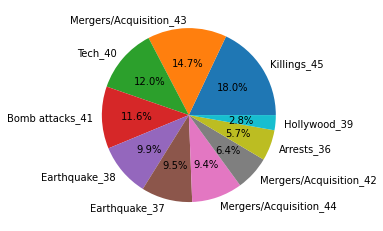

In [28]:
import matplotlib.pyplot as plt
# labels = ['Frogs', 'Hogs', 'Dogs', 'Logs']
# sizes = [15, 30, 45, 10]

# labels = list(topic_count_lm_v.values())
# sizes = [15, 30, 45, 10]
 
# fig, ax = plt.subplots()
# ax.pie(sizes, labels=labels)

fig, ax = plt.subplots()
ax.pie(list(label_dict_lm_v.keys()), labels=list(label_dict_lm_v.values()), autopct='%1.1f%%', )
plt.show()
fig.savefig('topic_dist_lm_v.png', bbox_inches='tight')

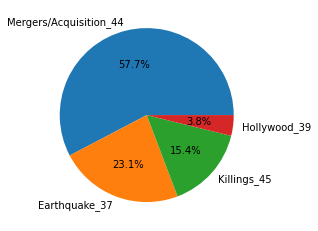

In [40]:
fig, ax = plt.subplots()
ax.pie(list(label_dict_v_lm.keys()), labels=list(label_dict_v_lm.values()), autopct='%1.1f%%', )
plt.show()
fig.savefig('topic_dist_v_lm.png', bbox_inches='tight')



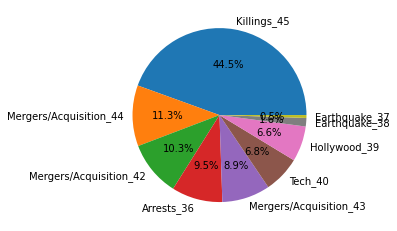

In [49]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.pie(list(label_dict_v_lm_inc.keys()), labels=list(label_dict_v_lm_inc.values()), autopct='%1.1f%%', )
plt.show()
fig.savefig('topic_dist_v_lm_inc.png', bbox_inches='tight')

# Time ML classification 




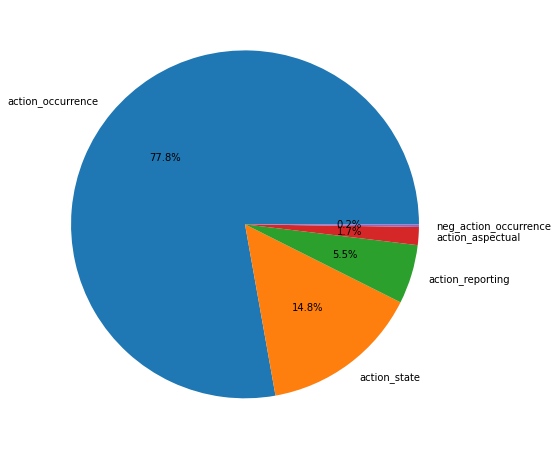

In [51]:
import matplotlib.pyplot as plt
#plt.figure(figsize = (24, 24))
fig, ax = plt.subplots(figsize=(19, 8))

ax.pie(list(coref_type_v_lm_inc.values()), labels=list(coref_type_v_lm_inc.keys()), autopct='%1.1f%%', )
plt.show()
#fig.savefig('topic_dist_v_lm_inc.png', bbox_inches='tight')
#coref_type_v_lm_inc

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)

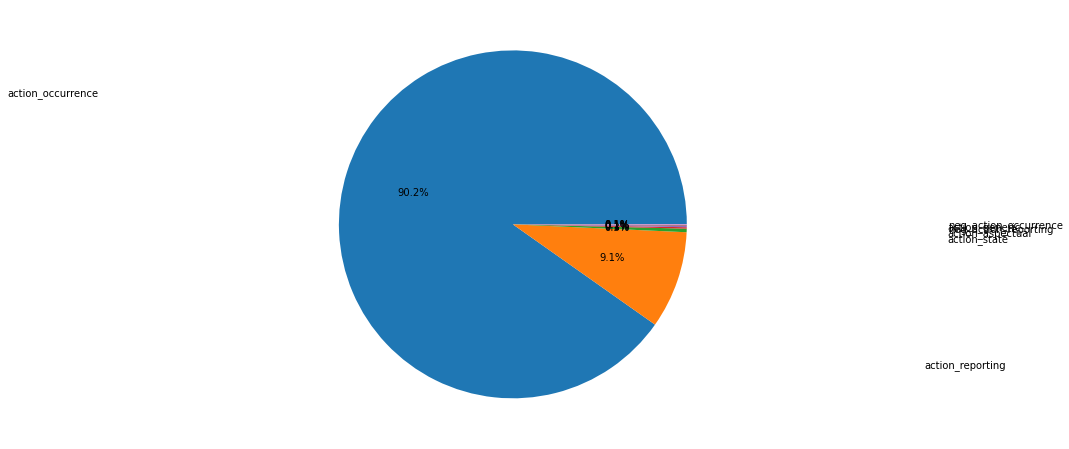

In [100]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(19, 8))
ax.pie(list(coref_type_lm_v.values()), labels=list(coref_type_lm_v.keys()), autopct='%1.1f%%'  , labeldistance=2.5)
plt.show()

In [50]:
dic = {'Class a': 26.9,
       'Class b': 18,
       'Class c': 16.8,
       'Class d': 13,
       'Class e': 8.83,
       'Class f': 5.97,
       'Class g': 3.59,
       'Class h': 2.01,
       'Class i': 1.42,
       'Class j': 1.09,
       'Class k': 0.903,
       'Class l': 0.873,
       'Class m': 0.28,
       'Class n': 0.24,
       'Class o': 0.112}

# group together all elements in the dictionary whose value is less than 2
# name this group 'All the rest'
import itertools
newdic={}
for key, group in itertools.groupby(coref_type_v_lm_, lambda k: 'All the rest' if (coref_type_v_lm_inc[k]<14) else k):
     newdic[key] = sum([coref_type_v_lm_inc[k] for k in list(group)])   

labels = newdic.keys()
sizes = newdic.values()

fig, ax = plt.subplots()

ax.pie(sizes, labels=labels, autopct='%1.1f%%', explode=(0,0,0,0,.1), startangle=0)
ax.axis('equal')
plt.tight_layout()

plt.show()

NameError: name 'coref_type_v_lm_' is not defined

In [53]:
 newdic

{'action_occurrence': 2750,
 'action_reporting': 276,
 'action_state': 10,
 'All the rest': 12}

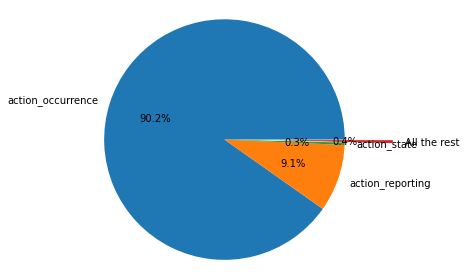

In [52]:
newdic={}
for key, group in itertools.groupby(coref_type_lm_v, lambda k: 'All the rest' if (coref_type_lm_v[k]<5) else k):
     newdic[key] = sum([coref_type_lm_v[k] for k in list(group)])   

labels = newdic.keys()
sizes = newdic.values()
myexplode = [0, 0, 0, 0.3]
fig, ax = plt.subplots()

ax.pie(sizes, labels=labels, autopct='%1.1f%%', explode=(0,0,0,.4), startangle=0, )
ax.axis('equal')
plt.tight_layout()

plt.show()

In [79]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array([35, 25, 25, 15])
mylabels = ["Tomatoes", "Mangoes", "Oranges", "Apples"]
myexplode = [0.2, 0, 0, 0]

plt.pie(y, labels = mylabels, explode = myexplode)
plt.show() 

dict_keys(['action_occurrence', 'action_reporting', 'action_state', 'All the rest'])

In [80]:
sizes

dict_values([2750, 276, 10, 12])

In [77]:
coref_type_lm_v, Counter({'action_occurrence': 13395,
         'action_state': 486,
         'action_reporting': 1395,
         'action_causative': 53,
         'action_generic': 9,
         'neg_action_reporting': 77,
         'neg_action_occurrence': 83,
         'neg_action_state': 8,
         'action_aspectual': 70})

{'action_occurrence': 2750,
 'action_reporting': 276,
 'action_state': 10,
 'action_aspectual': 4,
 'neg_action_reporting': 4,
 'action_generic': 2,
 'neg_action_occurrence': 2}

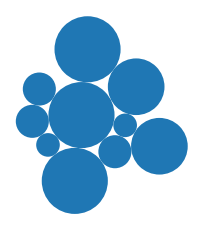

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# create 10 circles with different radii
r = np.random.randint(5,15, size=10)

class C():
    def __init__(self,r):
        self.N = len(r)
        self.x = np.ones((self.N,3))
        self.x[:,2] = r
        maxstep = 2*self.x[:,2].max()
        length = np.ceil(np.sqrt(self.N))
        grid = np.arange(0,length*maxstep,maxstep)
        gx,gy = np.meshgrid(grid,grid)
        self.x[:,0] = gx.flatten()[:self.N]
        self.x[:,1] = gy.flatten()[:self.N]
        self.x[:,:2] = self.x[:,:2] - np.mean(self.x[:,:2], axis=0)

        self.step = self.x[:,2].min()
        self.p = lambda x,y: np.sum((x**2+y**2)**2)
        self.E = self.energy()
        self.iter = 1.

    def minimize(self):
        while self.iter < 1000*self.N:
            for i in range(self.N):
                rand = np.random.randn(2)*self.step/self.iter
                self.x[i,:2] += rand
                e = self.energy()
                if (e < self.E and self.isvalid(i)):
                    self.E = e
                    self.iter = 1.
                else:
                    self.x[i,:2] -= rand
                    self.iter += 1.

    def energy(self):
        return self.p(self.x[:,0], self.x[:,1])

    def distance(self,x1,x2):
        return np.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2)-x1[2]-x2[2]

    def isvalid(self, i):
        for j in range(self.N):
            if i!=j: 
                if self.distance(self.x[i,:], self.x[j,:]) < 0:
                    return False
        return True

    def plot(self, ax):
        for i in range(self.N):
            circ = plt.Circle(self.x[i,:2],self.x[i,2] )
            ax.add_patch(circ)

c = C(r)

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
ax.axis("off")

c.minimize()

c.plot(ax)
ax.relim()
ax.autoscale_view()
plt.show()
 

In [56]:
!pip install circlify

In [58]:
from pprint import pprint as pp
import circlify as circ
circles = circ.circlify([19, 17, 13, 11, 7, 5, 3, 2, 1], show_enclosure=True)
pp(circles)

[Circle(x=0.0, y=0.0, r=1.0, level=0, ex=None),
 Circle(x=-0.633232604611031, y=-0.47732413442115296, r=0.09460444572843042, level=1, ex={'datum': 1}),
 Circle(x=-0.7720311587589236, y=0.19946176418549022, r=0.13379089020993573, level=1, ex={'datum': 2}),
 Circle(x=-0.43168871955473165, y=-0.6391381648617572, r=0.16385970662353394, level=1, ex={'datum': 3}),
 Circle(x=0.595447603036083, y=0.5168251295666467, r=0.21154197162246005, level=1, ex={'datum': 5}),
 Circle(x=-0.5480911056188739, y=0.5115139053491098, r=0.2502998363185337, level=1, ex={'datum': 7}),
 Circle(x=0.043747233552068686, y=-0.6848366902134195, r=0.31376744998074435, level=1, ex={'datum': 11}),
 Circle(x=0.04298737651230445, y=0.5310431146935967, r=0.34110117996070605, level=1, ex={'datum': 13}),
 Circle(x=-0.3375943908160698, y=-0.09326467617622711, r=0.39006412239133215, level=1, ex={'datum': 17}),
 Circle(x=0.46484095011516874, y=-0.09326467617622711, r=0.4123712185399064, level=1, ex={'datum': 19})]


In [ ]:
45_3ecbplus.xml_27', '45_3ecbplus.xml_24') 

In [ ]:
#highest positive sim pair: easiet ('36_9ecbplus.xml_30', '36_9ecbplus.xml_23')

evt_mention_map['36_9ecbplus.xml_30']['bert_sentence'], evt_mention_map['36_9ecbplus.xml_23']['bert_sentence']

In [ ]:
evt_mention_map['45_3ecbplus.xml_27']['bert_sentence'], evt_mention_map['45_3ecbplus.xml_24']['bert_sentence']

In [ ]:
#best easy example, 
evt_mention_map['38_8ecbplus.xml_3']['bert_sentence'], evt_mention_map['38_8ecbplus.xml_1']['bert_sentence']

In [ ]:
#hard example from negtaive  ('40_3ecbplus.xml_19', '40_3ecbplus.xml_18')

# evt_mention_map['37_3ecb.xml_57']['bert_doc'], evt_mention_map['37_3ecb.xml_53']['bert_doc']
evt_mention_map['40_3ecbplus.xml_19']['bert_doc'], evt_mention_map['40_3ecbplus.xml_18']['bert_doc']


In [ ]:
##hard example from negtaive  ( ('37_3ecb.xml_57', '37_3ecb.xml_53')	1.0

# evt_mention_map['37_3ecb.xml_57']['bert_doc'], evt_mention_map['37_3ecb.xml_53']['bert_doc']

In [ ]:
# easy negative ('41_9ecb.xml_62', '41_6ecb.xml_58')

evt_mention_map['41_9ecb.xml_62']['bert_sentence'], evt_mention_map['41_6ecb.xml_58']['bert_sentence']

In [ ]:
#  hard pos example ( '44_6ecbplus.xml_85', '44_10ecbplus.xml_14')
evt_mention_map['44_6ecbplus.xml_85']['bert_sentence'], evt_mention_map['44_10ecbplus.xml_14']['bert_sentence']

In [ ]:
df.loc[(df['coref_label']==1) & (df['pair'][0]=='45_6ecb.xml_100')] 

In [ ]:
df['pair'].str.replace("'",'').replace("(",'')

df['pair1'] = df['pair'].str[0]
df['pair2'] = df['pair'].str[1]

In [ ]:
df 

In [ ]:
evt_mention_map['36_1ecbplus.xml_15']['bert_sentence'], evt_mention_map['36_1ecbplus.xml_14']['bert_sentence']

In [ ]:
evt_mention_map['45_8ecb.xml_25']['bert_sentence'], evt_mention_map['45_6ecb.xml_100']['bert_sentence']

In [ ]:
pos_pairs = []
c=0
for x, y in evt_mention_map.items():
    for i, j in test_pairs:
        
    
        if x =='45_6ecb.xml_100'and i == '45_6ecb.xml_100':
            pos_pairs.append((x,j))
        
   

In [ ]:
pos = []
for i in pos_pairs:
    for x, y in evt_mention_map.items():
        if i[1]==x:
            pos.append((i[1],y['gold_cluster']))
            
     
    
        
        
   

In [ ]:
pos'ACT18223792344828287'

In [ ]:
for i in pos_pairs:
    print(i[0])
    
    #print(evt_mention_map[i[0]['gold_cluster']])
        
    

In [ ]:
evt_mention_map['45_1ecb.xml_94']['lemma'], evt_mention_map['45_6ecb.xml_100']['bert_sentence']

In [ ]:

#getting TP distribution
tp = []
fp = []
fn = []
tn = []
tp_easy = []
tp_hard = []
fp_easy = []
fp_hard = []

fn_easy = []
fn_hard = []
tn_easy = []
tn_hard = []
feature_list  = ['LM_prediction', 'VIT_LM',
       'LM_VIT', 'LM_SWIN', 'SWIN_LM', 'BEIT_LM', 'LM_BEIT', 'LM_CLIP',
       'CLIP_LM', 'VIT+LM', 'SWIN+LM', 'BEIT+LM', 'CLIP+LM']
for x, y in enumerate(feature_list):
    

    tp_easy , tp_hard = len(df.loc[(df[y]==1) & (df['coref_label']==1) & (df['sem_label']==1) ]), len(df.loc[(df[y]==1) & (df['coref_label']==1) & (df['sem_label']==0) ])
    
    fp_easy, fp_hard = len(df.loc[(df[y]==1) & (df['coref_label']==0) & (df['sem_label']==1) ]), len(df.loc[(df[y]==1) & (df['coref_label']==0) & (df['sem_label']==0) ])
    fn_easy, fn_hard = len(df.loc[(df[y]==0) & (df['coref_label']==1) & (df['sem_label']==1) ]), len(df.loc[(df[y]==0) & (df['coref_label']==1) & (df['sem_label']==0) ])
    tn_easy, tn_hard = len(df.loc[(df[y]==0) & (df['coref_label']==0) & (df['sem_label']==1) ]), len(df.loc[(df[y]==0) & (df['coref_label']==0) & (df['sem_label']==0) ])
    
    
    #easy 2048, hard 1784, total 3832, get hard/easy: 
    
    
    tp.append([y, tp_easy, tp_hard, tp_hard/(tp_easy+tp_hard),tp_easy/(tp_easy+tp_hard) ])
    print(y)
    try:
        fp_hard_prop = fp_hard/(fp_easy+fp_hard)
        fn_hard_prop=  fn_hard/(fn_easy+fn_hard)
        tn_hard_prop =  tn_hard/(tn_easy+tn_hard)
        
        fp_hard_prop = fp_hard/(fp_easy+fp_hard)
        fn_hard_prop=  fn_hard/(fn_easy+fn_hard)
        tn_hard_prop =  tn_hard/(tn_easy+tn_hard)
    except:
        fp_hard_prop= 0
        fn_hard_prop =0
        tn_hard_prop = 0
        
    fp.append([y, fp_easy, fp_hard,fp_hard_prop])
    fn.append([y, fn_easy, fn_hard,fn_hard_prop])
    tn.append([y, tn_easy, tn_hard, tn_hard_prop])
    

In [ ]:
tp, fp, fn, tn

In [ ]:
TP_table = pd.DataFrame(list(tp), columns = ['model', 'easy','hard', 'hard_proportion' , 'easy_proportion' ])
FP_table = pd.DataFrame(list(fp), columns = ['model', 'easy','hard', 'hard_proportion'  ])
FN_table = pd.DataFrame(list(fn), columns = ['model', 'easy','hard', 'hard_proportion'  ])
TN_table = pd.DataFrame(list(tn), columns = ['model', 'easy','hard', 'hard_proportion'  ])

In [ ]:
FP_table['easy_prortion']= 1 - FP_table['hard_proportion']  
FN_table['easy_prortion']= 1 - FP_table['hard_proportion']  
TN_table['easy_prortion']= 1 - FP_table['hard_proportion']  

In [ ]:
# TP_table.to_csv('TP_table.csv')
# FP_table.to_csv('FP_table.csv')
# FN_table.to_csv('FN_table.csv')
# TN_table.to_csv('TN_table.csv')

TP = pd.read_csv('TP_table.csv')
FP = pd.read_csv('FP_table.csv')
FN = pd.read_csv('FN_table.csv')
TN = pd.read_csv('TN_table.csv')

In [ ]:
df_list = [zip(TP, FP, FN)]
#df_new = pd.DataFrame(TP['model'],TP['easy'])
df_new = pd.concat([TP['model'], TP['hard_proportion'], FP['hard_proportion'], FN['hard_proportion'], TN['hard_proportion']], axis =1 )
for index, row in df_new.iterrows():
    print(row[0],np.round(row[1],3), f"& {np.round(row[2],3)}", f"& {np.round(row[3],3)}")

In [ ]:
# TP_table  # semantic transfer via l maps are helping to resolve a higher proportion of challening examples comapred to LM native and fine tuned examples

# For both False positive and false negs i.e., misclassified samples , hard example proportions are more in fine-tuned models, that means fine-tuned models more prone to get fooled by harder pairs than the Lin Sem semantic transfer framework
for (x,y,z) in df_list:
    print(x['easy'], y['easy'], z['easy'] )

In [ ]:
FP_table # hard examples are more in fine-tuned models, that means hard example pairs easily fool the fine-tuned models 

In [ ]:
FN_table

In [ ]:
y = ['LM_BEIT']
tp_easy , tp_hard = len(df.loc[(df[y]==1) & (df['coref_label']==1) & (df['sem_label']==1) ]), len(df.loc[(df[y]==1) & (df['coref_label']==1) & (df['sem_label']==0) ])

fp_easy, fp_hard = len(df.loc[(df[y]==1) & (df['coref_label']==0) & (df['sem_label']==1) ]), len(df.loc[(df[y]==1) & (df['coref_label']==0) & (df['sem_label']==0) ])
fn_easy, fn_hard = len(df.loc[(df[y]==0) & (df['coref_label']==1) & (df['sem_label']==1) ]), len(df.loc[(df[y]==0) & (df['coref_label']==1) & (df['sem_label']==0) ])
tn_easy, tn_hard = len(df.loc[(df[y]==0) & (df['coref_label']==0) & (df['sem_label']==1) ]), len(df.loc[(df[y]==0) & (df['coref_label']==0) & (df['sem_label']==0) ])

In [ ]:
len(df.loc[(df[y]==0) & (df['coref_label']==0) & (df['sem_label']==1) ]), len(df.loc[(df[y]==0) & (df['coref_label']==0) & (df['sem_label']==0) ])

In [ ]:
len(test_pairs)

In [ ]:
df.loc[df['wup_sim']>0]['wup_sim'].min()

In [ ]:
sem_pos = df.loc[df['coref_label']==1]['sem_total'] >= df.loc[df['coref_label']==1]['sem_total'].mean()
sem_pos = sem_pos.astype(int)
sem_neg = df.loc[df['coref_label']==0]['sem_total'] <= df.loc[df['coref_label']==0]['sem_total'].mean()
sem_neg = sem_neg.astype(int)

In [ ]:
len(sem_pos), len(sem_neg)

In [ ]:
sem_label  = list(sem_pos) + list(sem_neg)
df.loc[(df['coref_label']==0) & (df['sem_label']==0)]

In [ ]:
df.loc[(df['coref_label']==0) & (df['all_total']>3)]  #1.88778 mean of total sims for negative coref labels, 2.1258 for positive labels 



In [ ]:
df

In [ ]:
evt_mention_map

In [ ]:
len(has_pron) # 333 pronouns, 12 numbers, 6 Deter, 678 propernoun 

In [ ]:
topic_list = []
mention_list = []
has_pron = []
wup_list = []
pos_list = []



for pair in tqdm(test_pairs, desc='Generating Similarities'):
    men1, men2 = pair
    men_map1 = evt_mention_map[men1]
    men_map2 = evt_mention_map[men2]
    men_text1 = men_map1['topic'] 
    men_text2 = men_map2['topic'] 
    topic_list.append((men_map1['lemma'].lower(), men_map2['lemma'].lower()))
    mention_list.append((men_map1['mention_text'].lower(), men_map2['mention_text'].lower()))
#     print(men_map1['lemma'].lower().strip('"')),print(men_map2['lemma'].lower().strip('"'))
#     print(men_map1['pos']),print(men_map2['pos'] )


    try:
        if men_map1['pos'] =='NUM' or men_map2['pos'] =='NUM':
    #         syn1 = wordnet.synsets(men_map1['mention_text'].lower().strip('"'))[0]
    #         syn2 = wordnet.synsets(men_map2['lemma'].lower().strip('"'))[0]
    #         wup = syn1.wup_similarity(syn2)
            wup_list.append(0)
    #         has_pron.append("yes")
    # #         continue
        elif men_map1['pos'] =='PRON' or men_map2['pos'] =='PRON':
            wup_list.append(0)
    #         continue

        elif men_map1['pos'] =='DET' or men_map2['pos'] =='DET':
            wup_list.append(0)
        elif men_map1['pos'] =='PROPN' or men_map2['pos'] =='PROPN':
            wup_list.append(0)
            
        elif men_map1['pos'] =='PROPN' or men_map2['pos'] =='PROPN':
            wup_list.append(0)
            #has_pron.append("yes")

    #         continue



        else: 

            syn1 = wordnet.synsets(men_map1['lemma'].lower().strip('"').replace("'", ""))[0]
            syn2 = wordnet.synsets(men_map2['lemma'].lower().strip('"').replace("'", ""))[0]
            wup = syn1.wup_similarity(syn2)
            wup_list.append(wup)
    except:
        wup_list.append(0)
        pos_list.append((men_map1['lemma'].lower().strip('"').replace("'", ""), men_map2['lemma'].lower().strip('"').replace("'", ""),men_map1['pos'], men_map2['pos'] ))
        
        
        

        
        #has_pron.append("yes")
    
    
    
    #print(wup)


In [ ]:
syn1 = wordnet.synsets('second-degree') 
#syn2 = wordnet.synsets('magnitude')[0]
np.array(wup_list).mean()

In [ ]:
def get_wup_sim(men_map1, men_map2):
    
    try:
        if men_map1['pos'] =='NUM' or men_map2['pos'] =='NUM':
    #         syn1 = wordnet.synsets(men_map1['mention_text'].lower().strip('"'))[0]
    #         syn2 = wordnet.synsets(men_map2['lemma'].lower().strip('"'))[0]
    #         wup = syn1.wup_similarity(syn2)
            wup_list.append(0)
    #         has_pron.append("yes")
    # #         continue
        elif men_map1['pos'] =='PRON' or men_map2['pos'] =='PRON':
            wup_list.append(0)
    #         continue

        elif men_map1['pos'] =='DET' or men_map2['pos'] =='DET':
            wup_list.append(0)
        elif men_map1['pos'] =='PROPN' or men_map2['pos'] =='PROPN':
            wup_list.append(0)
            
        elif men_map1['pos'] =='PROPN' or men_map2['pos'] =='PROPN':
            wup_list.append(0)
            #has_pron.append("yes")

    #         continue



        else: 

            syn1 = wordnet.synsets(men_map1['lemma'].lower().strip('"').replace("'", ""))[0]
            syn2 = wordnet.synsets(men_map2['lemma'].lower().strip('"').replace("'", ""))[0]
            wup = syn1.wup_similarity(syn2)
            wup_list.append(wup)
    except:
        wup_list.append(0)
        pos_list.append((men_map1['lemma'].lower().strip('"').replace("'", ""), men_map2['lemma'].lower().strip('"').replace("'", ""),men_map1['pos'], men_map2['pos'] ))
    return np.array(wup_list)

In [ ]:
syn1

In [ ]:
similarities,l_sim, s_sim,   = lh_oracle('ecb', threshold=0.05)

In [ ]:
 np.array(wup_list)

In [ ]:
evt_mention_map['topic']

In [ ]:
import torch.nn as nn
import torch
input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output = cos(input1, input2)

In [ ]:
output 

In [ ]:
evt_mention_map['']